# Linear Regression 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
# reading the train and test dataset as one file
data = pd.read_csv('exported-job-all_06_05_2020_15_29_14.csv')
data.head(3)

,s_video_id,s_width,s_height,s_storage_size,s_duration,s_scan_type,c_content_category,c_si,c_ti,c_scene_change_ffmpeg_ratio30,...,e_b_frame_int,e_ref_frame_count,e_scan_type,e_bit_depth,e_pixel_fmt,t_average_bitrate,t_average_vmaf,t_average_vmaf_mobile,t_average_vmaf_4k,t_average_psnr
0,8,1920,1080,521709628,65,progressive,maze,63.04,14.48,11.076923,...,3,1.0,progressive,8.0,yuv420p,31214,97.204616,NaN,NaN,NaN
1,8,1920,1080,521709628,65,progressive,maze,63.04,14.48,11.076923,...,3,1.0,progressive,8.0,yuv420p,2750,67.255472,NaN,NaN,NaN
2,8,1920,1080,521709628,65,progressive,maze,63.04,14.48,11.076923,...,3,1.0,progressive,8.0,yuv420p,10777,90.423618,NaN,NaN,NaN


In [3]:
#delete rows where target variable is nan
NaN = data['t_average_vmaf'][data['t_average_vmaf'].isna()] 
print(NaN)
data.dropna(subset = ['t_average_vmaf'] , inplace = True)
#print('\nNumber of the rows and columns of training data after deleting the NaN :',data.shape)


3354    NaN
5811    NaN
6162    NaN
6255    NaN
6305    NaN
         ..
10565   NaN
10566   NaN
10567   NaN
10568   NaN
10569   NaN
Name: t_average_vmaf, Length: 392, dtype: float64


In [4]:
#change inttype
data = data.astype(dict.fromkeys(data.select_dtypes(np.int64).columns, np.int32))

In [5]:
#Use the metadata which is independent of the encodes
meta_data = data[[x for x in data.columns if not (x.startswith('e') or x.startswith('t'))]]

In [6]:
#Read the columns from the encoded version in meta data that are needed for prediciton
meta_data.loc[:,'t_average_bitrate'] = data.loc[:,'t_average_bitrate']
meta_data.loc[:,'e_width'] = data.loc[:,'e_width']
meta_data.loc[:,'e_height']= data.loc[:,'e_height']

In [7]:
#drop video id, because we don't need here
meta_data = meta_data.drop('s_video_id', axis = 1)

#drop scan type because in every row with same value: progressive
meta_data = meta_data.drop('s_scan_type', axis = 1)

In [8]:
# Now, we need to predict the target variable in the test data
# target variable - t_average_vmaf
vmaf = data['t_average_vmaf']

In [9]:
#get_dummies for categorical variable to convert categorical variable into dummy/indicator (here: c_content_category) variables
content_types = pd.get_dummies(meta_data["c_content_category"],prefix='c_content_category')
meta_data = meta_data.drop("c_content_category", axis = 1)
#print(content_types.head(4))
meta_data = pd.concat([meta_data, content_types], axis = 1, sort = False)

In [10]:
#To ignore the error: "Input contains NaN, infinity or a value too large for dtype('float64')."
meta_data = meta_data.apply(lambda x: x.fillna(x.mean()),axis=0)
vmaf=vmaf.fillna(vmaf.mean())

In [11]:
#Seperate the independent and target variable on training data and test data
X_train, X_test, y_train, y_test = train_test_split(meta_data, vmaf,test_size=0.33, random_state=101)

#Drop variables that worsen prediction
X_train.drop(['s_storage_size', 's_duration'], axis = 1, inplace=True)
X_test.drop(['s_storage_size', 's_duration'], axis = 1, inplace=True)

In [12]:
# Create linear regression object
regr_model = linear_model.LinearRegression()
#Train the model using the training sets
regr_model.fit(X_train, y_train)
# Make predictions using the testing set
y_pred = regr_model.predict(X_test)


In [13]:
print('Mean Absolute Error: %.4f' % mean_absolute_error(y_test, y_pred))
print('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error: %.4f' % mean_squared_error(y_test, y_pred)**(0.5))

Mean Absolute Error: 20.7235
Mean squared error: 581.4686
Root Mean Squared Error: 24.1137


In [14]:
def generate_data(data, bit_rate_step=50, max_bitrate = 2500, min_birate = 50, widths=[1280,  960, 1920,  640,  416,  768], heights = [720,  540, 1080,  360,  234,  432], col_names=['e_height','e_width', 't_average_bitrate']):
    generated=pd.DataFrame()
    for bitrate in range(min_birate,max_bitrate,bit_rate_step):
        for width in widths:
            for height in heights:
                data[col_names[0]]=height
                data[col_names[1]]=width
                data[col_names[2]]=bitrate
                generated = generated.append(data, ignore_index = True)
    return generated

def get_data_at_highest_vmaf_per_bps(data):
    best_per_bitrate = pd.DataFrame(columns = data.columns)
    for bitrate in data['t_average_bitrate'].unique():
        df_tmp = data[data['t_average_bitrate']==bitrate]
        best_vmaf = df_tmp[df_tmp['t_average_vmaf']==df_tmp['t_average_vmaf'].max()]
        best_per_bitrate = best_per_bitrate.append(best_vmaf)
    return best_per_bitrate

def get_encoding_latter(best_per_bitrate):
    sorted_df = best_per_bitrate.sort_values('t_average_vmaf')
    jnd_df = pd.DataFrame(sorted_df.head(n=1))
    for i in range(1,len(sorted_df)):
        if not (sorted_df.iloc[i,-1]-jnd_df.iloc[-1,-1])<6:
            jnd_df = jnd_df.append(sorted_df.iloc[i,:], ignore_index = True)
    return jnd_df


In [15]:
# artifical "new" movie instance 
new_instance = X_test.head(n=1)

#generate the bitrates and resolutions in a step of bps
new_data = generate_data(new_instance)

#predict 
y_pred_new_data = regr_model.predict(new_data)
new_data['t_average_vmaf'] = y_pred_new_data

#get highest vmaf at each resolution 
best_encodings_per_bitrate = get_data_at_highest_vmaf_per_bps(new_data)

#get those with a minimum of 6 vmaf score difference (=1 jnds)
encoding_df = get_encoding_latter(best_encodings_per_bitrate)

#check when (at which bps) to switch resolution and to which resolution
print(encoding_df[['e_width', 'e_height', 't_average_bitrate', "t_average_vmaf"]])


  e_width e_height t_average_bitrate  t_average_vmaf
0    1920     1080                50       53.433748
1    1920     1080               800       59.484700
2    1920     1080              1550       65.535652
3    1920     1080              2300       71.586603


No handles with labels found to put in legend.


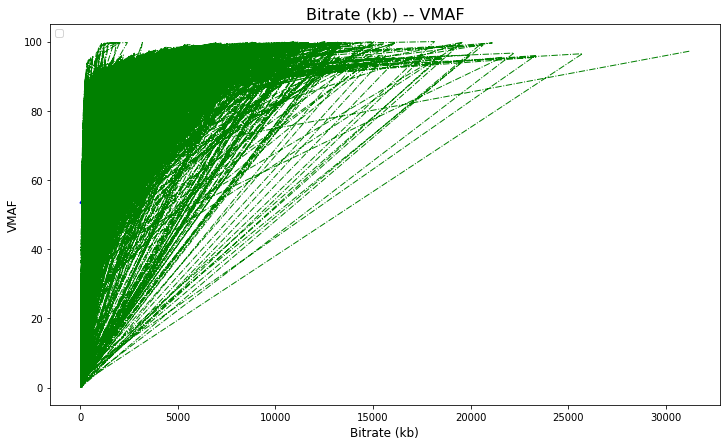

In [54]:
# Plot the computed Convex Hull:
plt.figure(figsize=(12,7))
plt.title("Bitrate (kb) -- VMAF", fontsize=16)
plt.xlabel("Bitrate (kb)", fontsize=12)
plt.ylabel("VMAF", fontsize=12)

plt.plot(encoding_df['t_average_bitrate'], encoding_df['t_average_vmaf'], color="blue", linewidth=3, picker=5)
plt.plot(meta_data['t_average_bitrate'], vmaf, color="green", linewidth=1, linestyle='dashdot', picker=5)
plt.legend(loc=2)
plt.show()


352 X 288
720 X 486
1080 X 1080
1280 X 720
1920 X 1080


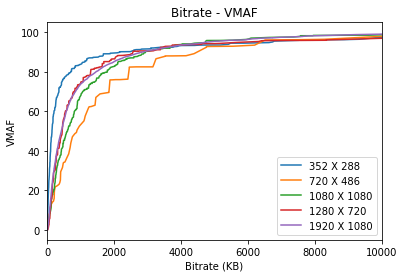

In [96]:
#print(sorted(d["t_average_bitrate"][(d['s_width']==1080) & (d['s_height']==1080)]))
# def unique_weight(list1): 
#     # insert the list to the set 
#     list_set = set(list1) 
#     # convert the set to the list 
#     unique_list = (list(list_set)) 
#     ret_list = []
#     for x in unique_list: 
#         ret_list.append(x)
#     return unique_list

d = data
unique_resolution = d.groupby(['s_width', 's_height'], as_index=False).size()
fig = plt.figure()
ax  = plt.subplot()
for x in unique_resolution.index[:]:
    width, height = x
    print(width,"X", height)
    x_bitrate = sorted(d['t_average_bitrate'][(d['s_width']==width) & (d['s_height']==height)])
    y_vmaf = sorted(d['t_average_vmaf'][(d['s_width']==width) & (d['s_height']==height)])
    ax.plot(x_bitrate, y_vmaf, label="{} X {}".format(width,height))
    plt.title('Bitrate - VMAF')
    plt.xlabel("Bitrate (KB)")
    plt.ylabel("VMAF")
ax.legend()
plt.xlim(0, 10000)
plt.show() 

In [97]:
print(r2_score(y_test, y_pred))

0.42447352933262716
